In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pybedtools import BedTool
from pybedtools.cbedtools import Attributes
from scipy.stats import fisher_exact, chi2
import scipy.sparse as sparse

## Annotate to nearest gene

In [62]:
genebed = BedTool('/home/wmzh22/utils/gencode.v19.protein_coding.gtf').sort()

In [63]:
trait = ['eGFR', 'FFR', 'glucose', 'gammaGT', 'prate']
m = 'sparsepro_baseline'

In [64]:
name_dict = {'eGFR': 'eGFR', 
             'FFR': 'FFR',
             'glucose': 'Glucose', 
             'gammaGT': 'gamma-GT', 
             'prate': 'Pulse rate'}

In [65]:
def get_nearest_gene(cs, genebed, tr, name_dict):
    allchr = [[int(j.split('.')[0]) for j in i.split('/')][0] for i in cs['cs']]
    allpos = [[int(j.split('.')[1]) for j in i.split('/')] for i in cs['cs']]
    cs['chr'] = allchr
    cs['pos'] = [i[0] for i in allpos]
    cs['snp'] = [i.split('/')[0] for i in cs['cs']]
    cs['Chr']= ['chr' + str(i) for i in allchr]
    cs['Start']=[min(i) for i in allpos]
    cs['End']=[max(i) for i in allpos]
    cs['Beta']=[float(i.split('/')[0]) for i in cs['beta']]
    csbed = BedTool(cs[['Chr', 'Start', 'End']].values.tolist()).sort()
    cgene = csbed.closest(genebed, d=True)
    c2g = {'.'.join(i[:3]):Attributes(i[11])['gene_name'] for i in cgene}
    c2d = {'.'.join(i[:3]):int(i[12]) for i in cgene}
    cs.index=cs['Chr'] + '.' + cs['Start'].astype('str') + '.' + cs['End'].astype(str)
    cs.index.name='Region'
    cs['Nearest_gene']=pd.Series(c2g)
    cs['Distance_to_nearest_gene']=pd.Series(c2d)
    cs['Causal_set'] = cs['cs']
    cs['PIP'] = cs['pip']
    cs['phenotype'] = name_dict[tr]
    return cs

In [66]:
cslist = [pd.concat([pd.read_csv('../dat/GWAS/{}/{}/{}_{}.cs'.format(tr, m, tr, ch), sep='\t') for ch in range(1, 23)]) for tr in trait]

In [67]:
genelist = [get_nearest_gene(i, genebed, name, name_dict) for name,i in zip(trait,cslist)]

In [68]:
pheno = pd.concat(genelist)[['Nearest_gene', 'phenotype', 'chr', 'pos', 'snp', 'PIP']]

In [69]:
gene_counts = pheno.groupby('Nearest_gene')['phenotype'].nunique()

In [70]:
gene_counts[gene_counts==gene_counts.max()]

Nearest_gene
GCKR      4
GLIS3     4
RREB1     4
ZBTB38    4
Name: phenotype, dtype: int64

## LocusZoom

In [71]:
reverse_name = {value: key for key, value in name_dict.items()}

In [72]:
reverse_name

{'eGFR': 'eGFR',
 'FFR': 'FFR',
 'Glucose': 'glucose',
 'gamma-GT': 'gammaGT',
 'Pulse rate': 'prate'}

In [73]:
loci = 'GCKR'

In [74]:
df_loci = pheno.loc[pheno['Nearest_gene']==loci,]

In [75]:
df_loci

,Nearest_gene,phenotype,chr,pos,snp,PIP
Region,,,,,,
chr2.27730940.27730940,GCKR,eGFR,2,27730940,2.27730940.T.C,0.9999
chr2.27730940.27730940,GCKR,Glucose,2,27730940,2.27730940.T.C,0.9954
chr2.27730940.27730940,GCKR,gamma-GT,2,27730940,2.27730940.T.C,1.0
chr2.27730940.27742603,GCKR,Pulse rate,2,27730940,2.27730940.T.C,0.8529/0.0741/0.0622


In [90]:
df_R, df_ld_snps = load_ld_npz('/home/wmzh22/scratch/UKBBLD/chr{}_{}_{}'.format(ch, dst, ded))

In [106]:
for ph in df_loci['phenotype']:
    tr = reverse_name.get(ph)
    print(tr)
    df_ss = pd.read_csv('../dat/GWAS/{}/sparsepro_baseline/{}_{}.pip'.format(tr, tr, ch), sep='\t', header=None)
    df_ss['pos'] = [int(i.split('.')[1]) for i in df_ss[0]]
    df_ss = df_ss.loc[(lst<df_ss['pos']) & (df_ss['pos']<led),]
    df_ss['SNP'] = df_ss[0]
    df_ss['lead'] = [i==lead for i in df_ss['SNP']]
    df_ss['p'] = chi2.sf(df_ss[1]**2, df=1)
    df_ss['PIP'] = df_ss[2]
    df_ss['ld'] = df_R.loc[lsnp, df_ss['SNP']].values
    df_ss['chr'] = ch
    df_ss[['SNP', 'chr', 'pos', 'p', 'PIP', 'lead', 'ld']].to_csv('../doc/LocusZoom/{}_{}_{}.txt'.format(loci, tr, lsnp), sep='\t', header=True, index=False)

eGFR
glucose
gammaGT
prate


## Enrichment plot

In [2]:
trait = ['eGFR', 'FFR', 'glucose', 'gammaGT', 'prate']

In [3]:
name_dict = {'eGFR': 'eGFR', 
             'FFR': 'FFR',
             'glucose': 'Glucose', 
             'gammaGT': 'gamma-GT', 
             'prate': 'Pulse rate'}

In [4]:
tissue_dict = {'Adrenal_Pancreas': 'Adrenal/Pancreatic',
               'Cardiovascular': 'Cardiovascular',
               'CNS': 'CNS',
               'Connective_Bone': 'Connective',
               'GI': 'GI',
               'Hematopoietic': 'Hematopoietic',
               'Kidney': 'Kidney',
               'Liver': 'Liver',
               'Other': 'Other', 
               'SkeletalMuscle': 'Musculoskeletal'}

In [5]:
method_dict = {'sparsepro': 'SparsePro-',
               'sparsepro_baseline': 'SparsePro+',
               'sparsepro_poly': 'SparsePro+PolyFun'}

In [6]:
df_cts = pd.read_csv('../doc/dat_cts.txt', sep='\t')

In [7]:
df_cts.head()

,Trait,Tissue,Annotated,Unannotated
0,eGFR,Adrenal/Pancreatic,190,280
1,eGFR,Cardiovascular,203,267
2,eGFR,CNS,222,248
3,eGFR,Connective,202,268
4,eGFR,GI,268,202


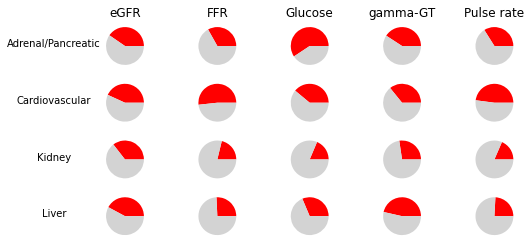

In [15]:
fig, axs = plt.subplots(4, 5, figsize=(8, 4))
for ax, row in zip(axs[0], trait):
    ax.set_title(name_dict[row], rotation=0, size='large')
for col, tissue in enumerate(['Adrenal_Pancreas', 'Cardiovascular', 'Kidney', 'Liver']):
    axs[col, 0].set_ylabel('{}'.format(tissue_dict[tissue]), rotation=0)
    axs[col, 0].yaxis.set_label_coords(-1.0, 0.45)
    for row, tr in enumerate(trait):
        values = df_cts.loc[(df_cts['Tissue']==tissue_dict[tissue]) & (df_cts['Trait']==name_dict[tr])].iloc[0, 2:]
        axs[col, row].pie(values, colors = ['red', 'lightgrey'])

In [71]:
df_p = pd.read_csv('../doc/dat_p.txt', sep='\t')

In [72]:
df_p

,Tissue,Trait1,Trait2,OR,p-value
0,Adrenal/Pancreatic,eGFR,eGFR,1.000,1.00000
1,Adrenal/Pancreatic,eGFR,FFR,1.370,0.03200
2,Adrenal/Pancreatic,eGFR,Glucose,0.465,0.00027
3,Adrenal/Pancreatic,eGFR,gamma-GT,0.985,0.94600
4,Adrenal/Pancreatic,eGFR,Pulse rate,1.320,0.09660
...,...,...,...,...,...
245,Musculoskeletal,Pulse rate,eGFR,0.914,0.58800
246,Musculoskeletal,Pulse rate,FFR,0.941,0.74600
247,Musculoskeletal,Pulse rate,Glucose,1.320,0.25900
248,Musculoskeletal,Pulse rate,gamma-GT,1.160,0.38000


In [23]:
df_trait_cts = pd.read_csv('../doc/dat_trait_cts.txt', sep='\t')

In [25]:
df_trait_cts

,Method,Trait,Tissue,W,W_se,p
0,SparsePro-,eGFR,Adrenal/Pancreatic,0.88,0.08,2.470000e-24
1,SparsePro-,eGFR,Cardiovascular,0.83,0.08,4.310000e-23
2,SparsePro-,eGFR,CNS,0.69,0.07,6.030000e-19
3,SparsePro-,eGFR,Connective,0.75,0.08,1.020000e-19
4,SparsePro-,eGFR,GI,0.86,0.07,5.230000e-31
...,...,...,...,...,...,...
145,SparsePro+PolyFun,Pulse rate,Hematopoietic,0.78,0.08,1.920000e-22
146,SparsePro+PolyFun,Pulse rate,Kidney,1.40,0.10,4.770000e-32
147,SparsePro+PolyFun,Pulse rate,Liver,1.19,0.09,1.630000e-31
148,SparsePro+PolyFun,Pulse rate,Other,1.05,0.08,3.620000e-39


In [33]:
df_trait_anno = pd.read_csv('../doc/dat_trait_anno.txt', sep='\t')

In [34]:
df_trait_anno

,Trait,Annotation,W,W_se,p
0,eGFR,Coding_UCSC,2.17,0.14,9.020000e-36
1,eGFR,Conserved_LindbladToh,1.90,0.13,9.200000e-33
2,eGFR,CTCF_Hoffman,0.35,0.26,2.620000e-01
3,eGFR,DGF_ENCODE,0.85,0.11,2.740000e-13
4,eGFR,DHS_Trynka,0.69,0.11,1.000000e-09
...,...,...,...,...,...
120,Pulse rate,WeakEnhancer_Hoffman,0.56,0.20,1.490000e-02
121,Pulse rate,synonymous,0.87,0.41,1.090000e-01
122,Pulse rate,non_synonymous,1.94,0.22,5.210000e-11
123,Pulse rate,Human_Promoter_Villar,1.02,0.18,1.650000e-06
